# [Computational Social Science] Project 5: Natural Language Processing

#### Hyemin Park

## PART 0: Base

In [2]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.manifold import TSNE

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## PART 1: Text Processing

In [3]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### data load
#congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets = pd.read_csv("C:/Users/OWNER/data/116th Congressional Tweets and Demographics.csv")


### confirm generated data
congress_tweets.head(n=5)


###' Data Generation
### create age column
congress_tweets['date'] = congress_tweets['datetime'].str[:10]
congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'])
congress_tweets['age'] = pd.to_numeric(congress_tweets['date'].str[:4]) - congress_tweets['birthday'].dt.year


### confirm generated data
congress_tweets.head(n=5)



###' ################################################################################
###'
###' Sellect Data
###'
###'

### select columns
congress_tweets_sel = congress_tweets[['tweet_id','party','position','gender','state','district_number','age','text']]
tweets = congress_tweets_sel.dropna(subset = ['text'])


### sample
tweets_party = pd.concat([tweets[tweets['party'] == 'Republican'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Democrat'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Independent'].sample(3000, random_state = 224)]).reset_index(drop = True)

In [4]:
###' ################################################################################
###'
###' Spell check for Random Sampled Text
###'
###'

### load spell checker
spell = SpellChecker()

### text spell check
tweets_party['text_spell'] = tweets_party['text'].map(lambda x: spell.correction(x))

### confirm generated data
tweets_party.head(n=10)

,tweet_id,party,position,gender,state,district_number,age,text,text_spell
0,1.227000e+18,Republican,Rep,M,NE,1,60,Ever had this happen? You make a reservation a...,Ever had this happen? You make a reservation a...
1,1.274420e+18,Republican,Sen,M,LA,Senate,63,ICYMI: Seniors are willing and able to give ba...,ICYMI: Seniors are willing and able to give ba...
2,1.274060e+18,Republican,Sen,M,CO,Senate,46,At Minton Park and Ballfield @SecretarySonny a...,At Minton Park and Ballfield @SecretarySonny a...
3,1.093520e+18,Republican,Rep,M,NC,8,48,I was thrilled to join @Pinecrest_MCS to recog...,I was thrilled to join @Pinecrest_MCS to recog...
4,1.243150e+18,Republican,Rep,M,MD,1,63,The Senate “emergency” bill allows sanctuary c...,The Senate “emergency” bill allows sanctuary c...
5,1.174680e+18,Republican,Rep,M,MO,7,64,RT @HouseCommerce All 2️⃣4️⃣ E&amp;C Republica...,RT @HouseCommerce All 2️⃣4️⃣ E&amp;C Republica...
6,1.225900e+18,Republican,Rep,M,AZ,4,62,Good riddance. https://twitter.com/jenniferjja...,Good riddance. https://twitter.com/jenniferjja...
7,1.242310e+18,Republican,Rep,M,TX,19,48,RT @DanScavino #WashYourHands #SlowTheSpread\n...,RT @DanScavino #WashYourHands #SlowTheSpread\n...
8,1.257800e+18,Republican,Rep,M,KY,4,49,@tbcw13 @usaf__vet This sentence could really ...,@tbcw13 @usaf__vet This sentence could really ...
9,1.141340e+18,Republican,Rep,M,TX,21,47,"RT @thehill .@RepChipRoy: ""[Rep. @AOC suggeste...","RT @thehill .@RepChipRoy: ""[Rep. @AOC suggeste..."


In [5]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "january", "february", "march", "april", "may", "june", "july", "august", "september", 
                    "october", "november", "december", "time", "today", "yesterday", "tomorrow", 
                    "day", "week", "month", "year","amp","RT","QT"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith("@")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith("http")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [6]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
tweets_party['tokens'] = tweets_party['text'].map(lambda x: rem_punc_stop(x))

tweets_party['tokens']

0       [happen, reservation, hotel, charge, resort, f...
1       [ICYMI, senior, willing, able, community, Covi...
2       [Minton, Park, Ballfield, SecretarySonny, I, s...
3       [I, thrilled, join, pinecrestmcs, recognize, C...
4       [Senate, ", emergency, ", bill, allow, sanctua...
                              ...                        
8995    [happy, help, ARCMaine, important, ", sound, A...
8996    [PplsAction, need, defeat, dangerous, presiden...
8997    [I, lot, thing, I, inconsistent, country, join...
8998    [farmworker, unrecognized, vital, contribution...
8999    [Supreme, Court, allow, Michigan, continue, ge...
Name: tokens, Length: 9000, dtype: object

## PART 2: Text Explore

In [7]:
###' ################################################################################
###'
###' GENERATE TEXT FEATURES
###' e.g. text_len, word count, polarity, subjectivity
###'
###'


# text_len & count
tweets_party['text_len'] = tweets_party['text_spell'].dropna().apply(len)
tweets_party['word_count'] = tweets_party['text_spell'].dropna().apply(lambda x: len(str(x).split()))


# join token
tweets_party['tokens_join'] = tweets_party['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


# polarity & subjectivity
tweets_party['polarity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)
tweets_party['subjectivity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### confirm generated data
tweets_party.head(n=5)

,tweet_id,party,position,gender,state,district_number,age,text,text_spell,tokens,text_len,word_count,tokens_join,polarity,subjectivity
0,1.227000e+18,Republican,Rep,M,NE,1,60,Ever had this happen? You make a reservation a...,Ever had this happen? You make a reservation a...,"[happen, reservation, hotel, charge, resort, f...",299.0,47.0,happen reservation hotel charge resort fee ’ r...,0.285714,0.535714
1,1.274420e+18,Republican,Sen,M,LA,Senate,63,ICYMI: Seniors are willing and able to give ba...,ICYMI: Seniors are willing and able to give ba...,"[ICYMI, senior, willing, able, community, Covi...",390.0,40.0,ICYMI senior willing able community Covid19 pr...,0.375000,0.687500
2,1.274060e+18,Republican,Sen,M,CO,Senate,46,At Minton Park and Ballfield @SecretarySonny a...,At Minton Park and Ballfield @SecretarySonny a...,"[Minton, Park, Ballfield, SecretarySonny, I, s...",342.0,35.0,Minton Park Ballfield SecretarySonny I speak l...,0.266667,0.333333
3,1.093520e+18,Republican,Rep,M,NC,8,48,I was thrilled to join @Pinecrest_MCS to recog...,I was thrilled to join @Pinecrest_MCS to recog...,"[I, thrilled, join, pinecrestmcs, recognize, C...",261.0,21.0,I thrilled join pinecrestmcs recognize Chris M...,0.550000,0.600000
4,1.243150e+18,Republican,Rep,M,MD,1,63,The Senate “emergency” bill allows sanctuary c...,The Senate “emergency” bill allows sanctuary c...,"[Senate, "", emergency, "", bill, allow, sanctua...",374.0,39.0,"Senate "" emergency "" bill allow sanctuary city...",0.200000,0.200000


### 1. Word Counts

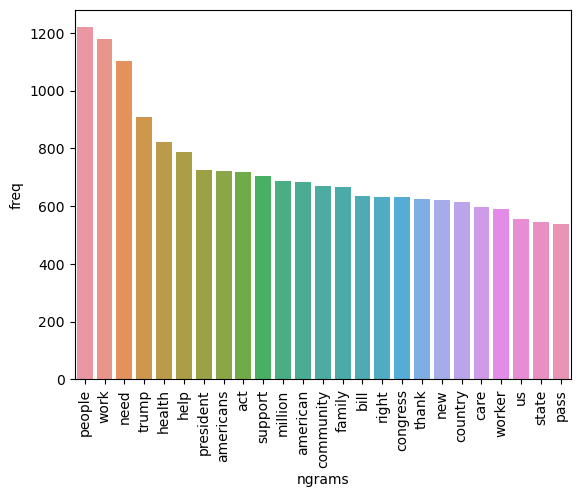

In [8]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ unigrams
###'
###'


### most frequent unigrams 
countvec = CountVectorizer(min_df = 5, ngram_range=(1,1))
ngrams = countvec.fit_transform(tweets_party['tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index()


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

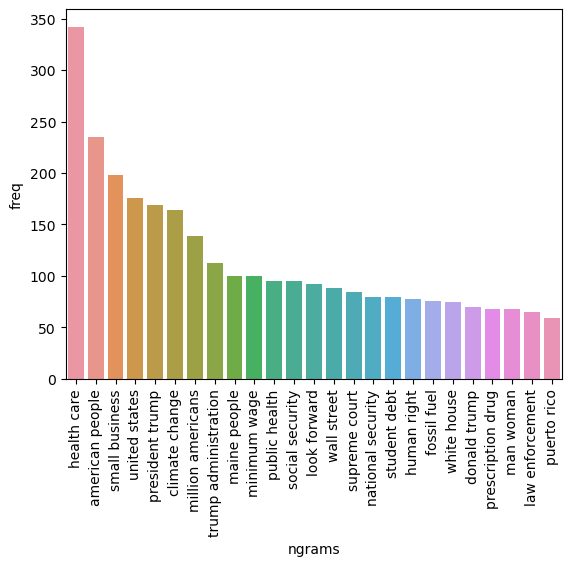

,small business,health care,american people,president trump,look forward,united states,trump administration,public health,national security,white house,...,house pass,social security,million americans,mental health,man woman,covid19 pandemic,supreme court,bipartisan bill,cares act,southern border
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
###' ################################################################################
###'
###' VISUALIZATION : WORDS COUNT
###' _ bigrams, trigrams
###'
###'


### most frequent bigrams 
countvec = CountVectorizer(min_df = 5, ngram_range=(2,3))


### fit and transform on tokens
ngrams = countvec.fit_transform(tweets_party['tokens_join'])      


### create a dataframe 
dictionary_dataframe = pd.DataFrame(ngrams.todense(),
                                    columns = countvec.get_feature_names_out()) 


### organize a dataframe 
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], 
                                ascending = False).reset_index(drop = True)


### plot 
sns.barplot(x="ngrams", 
            y = "freq",
            data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()


###' ############### for classification
ngrams_S = countvec.fit_transform(tweets_party[tweets_party['party'] != 'Independent']['tokens_join'])
dictionary_dataframe_S = pd.DataFrame(ngrams_S.todense(),
                                      columns = countvec.get_feature_names_out()) 

df_ngram_S = pd.DataFrame(dictionary_dataframe_S.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram_S = df_ngram_S.sort_values(by = ['freq'],
                                    ascending = False).reset_index(drop = True)


### top_25_ngrams for classification
top_25_ngrams = dictionary_dataframe_S.loc[:,df_ngram_S[0:25]['ngrams']]
top_25_ngrams.head()

### 2. Topic Modeling

In [11]:
###' ################################################################################
###'
###' Topic Modeling : TD-IDF Matrix
###' by. party
###'
###'


### Republican

### create tf-idf matrix
tfidf = TfidfVectorizer(min_df = 5) 
tfidf_mx = tfidf.fit_transform(tweets_party['tokens_join'])


### convert matrix to an arrray and then to a dataframe
tfidf_df = pd.DataFrame(data = tfidf_mx.toarray(),
                        columns = tfidf.get_feature_names_out())


###' ############### for classification
tfidf_mx_S = tfidf.fit_transform(tweets_party[tweets_party['party'] != 'Independent']['tokens_join'])
tfidf_df_S = pd.DataFrame(data = tfidf_mx_S.toarray(),
                          columns = tfidf.get_feature_names_out())

#tfidf_df_S.T.nlargest(10,0)


## sort by term frequency on the first document
tfidf_df.T.nlargest(10,0)

,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
hotel,0.360357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nbc,0.360357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
deceptive,0.347887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fee,0.306054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
invite,0.306054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
practice,0.279220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charge,0.250301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
story,0.240174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
happen,0.224443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
news,0.211738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
###' ################################################################################
###'
###' Topic Modeling : Latent Dirichlet Allocation (LDA)
###'
###'

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


topic_0:
puerto equality rico marijuana daca lgbtq barrett climatecrisis raisethewage pipeline interview martin • hot unanimously jimjordan amy coney luther vermont

topic_1:
saudi barr mueller arabia saudile hong kong foxnew brutal de spy override zelensky privacy delta antisemitism monitor la quo dictatorship

topic_2:
I people work need trump health president help americans – family — american support community ' act care right million

topic_3:
happy birthday behavior jane mother ohio flotus dependent favorite repwesterman climateactionnow rescue markup signing turkey shield burn oklahoma vanessa pray

topic_4:
de la el term y que diversity pfas johnson pray en para slavery del 🔥 stem los abolish reppaultonko catalyst



,0,1,2,3,4
0,0.324808,0.037883,0.561542,0.037885,0.037883
1,0.041619,0.041619,0.833526,0.041619,0.041619
2,0.039251,0.039283,0.715081,0.039256,0.167128
3,0.042885,0.042380,0.293281,0.042503,0.578951
4,0.038693,0.358427,0.525491,0.038695,0.038695
...,...,...,...,...,...
8995,0.043898,0.043900,0.824317,0.043984,0.043900
8996,0.045252,0.045147,0.542482,0.045150,0.321970
8997,0.039268,0.039270,0.842925,0.039269,0.039268
8998,0.041798,0.041671,0.665328,0.041673,0.209530
